In [1]:
from datasets import load_dataset
import random
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
bert_model_name = "dkleczek/bert-base-polish-cased-v1"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name, output_hidden_states=True)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(60000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [3]:
gpt2_model_name = "sdadas/polish-gpt2-medium"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_model = AutoModel.from_pretrained(gpt2_model_name, output_hidden_states=True)
gpt2_model.eval()

GPT2Model(
  (wte): Embedding(51200, 1024)
  (wpe): Embedding(2048, 1024)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-23): 24 x GPT2Block(
      (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=3072, nx=1024)
        (c_proj): Conv1D(nf=1024, nx=1024)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=4096, nx=1024)
        (c_proj): Conv1D(nf=1024, nx=4096)
        (act): FastGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [4]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

1. Wczytaj zbiór danych i wybierz z niego teksty z lematami
2. Mapowanie słów na zdania i odrzucenie słów nie występujących co najmniej 5 razy
3. wylosowanie n słów w kontekście
4. Sprawdzenie embeddingów wylosowanych słów ze względu na warstwę i policzenie podobieństwa
5. Utworzenie wykresu
6. 

In [5]:
def split_text_into_sentences_with_indices(text):
    pattern = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s')
    
    sentences = []
    start = 0
    
    for match in pattern.finditer(text):
        end = match.end()
        sentence = text[start:end].strip()
        sentences.append((sentence, start, end - 1))
        start = end

    if start < len(text):
        sentences.append((text[start:].strip(), start, len(text) - 1))

    return sentences

In [6]:
# sentences = {}
# words = {}

# for i, sample in enumerate(dataset['train']):
#     sentences[i] = {'text': sample['text'], 'lemma': sample['tokens']['lemma']}
#     for j, (lemma, pos) in enumerate(zip(sample['tokens']['lemma'], sample['tokens']['pos'])):
#         if pos == 'interp':
#             continue
#         if lemma not in words:
#             words[lemma] = []
#         words[lemma].append((i, j))

In [31]:
sentences = {}
words = {}

i = 0
for sample in dataset['train']:
    split_sentences = split_text_into_sentences_with_indices(sample['text'])
    prev_j = 0
    for sentence, start_idx, end_idx in split_sentences:
        for j in range(prev_j, len(sample['tokens']['position'])):
            if sample['tokens']['position'][j][1] == end_idx:
                if len(sentence) <= 512:
                    sentences[i] = {'text': sentence, 'lemma': sample['tokens']['lemma'][prev_j : j + 1], 'orth': sample['tokens']['orth'][prev_j : j + 1]}
                    
                    for k, (lemma, pos) in enumerate(zip(sample['tokens']['lemma'][prev_j : j + 1], sample['tokens']['pos'][prev_j : j + 1])):
                        if pos == 'interp':
                            continue
                        if lemma not in words:
                            words[lemma] = []
                        words[lemma].append((i, k))

                prev_j = j + 1
                i += 1
                break

In [66]:
sentences

{0: {'text': 'Zatem to pani siostra o niego prosiła?',
  'lemma': ['zatem', 'to', 'pani', 'siostra', 'o', 'on', 'prosić', '?'],
  'orth': ['Zatem', 'to', 'pani', 'siostra', 'o', 'niego', 'prosiła', '?']},
 1: {'text': 'Skądże, nigdy nie słyszałam, żeby go używała.',
  'lemma': ['skądże',
   ',',
   'nigdy',
   'nie',
   'słyszeć',
   'być',
   ',',
   'żeby',
   'on',
   'używać',
   '.'],
  'orth': ['Skądże',
   ',',
   'nigdy',
   'nie',
   'słyszała',
   'm',
   ',',
   'żeby',
   'go',
   'używała',
   '.']},
 2: {'text': 'Zwykłyśmy obywać się bez służących.',
  'lemma': ['zwyknąć', 'być', 'obywać', 'się', 'bez', 'służący', '.'],
  'orth': ['Zwykły', 'śmy', 'obywać', 'się', 'bez', 'służących', '.']},
 3: {'text': 'W istocie, wydaje się niepotrzebnym umieszczanie tak porządnego sznura w tym miejscu.',
  'lemma': ['w',
   'istota',
   ',',
   'wydawać',
   'się',
   'niepotrzebny',
   'umieszczać',
   'tak',
   'porządny',
   'sznur',
   'w',
   'ten',
   'miejsce',
   '.'],
  'orth'

In [93]:
words

{'zatem': [(0, 0),
  (261, 0),
  (277, 1),
  (381, 1),
  (402, 1),
  (415, 9),
  (417, 2),
  (422, 1),
  (448, 0),
  (553, 1),
  (598, 1),
  (603, 0),
  (1873, 1),
  (2636, 3),
  (3187, 1),
  (3848, 2),
  (3966, 1),
  (4189, 3),
  (4744, 1),
  (5165, 1),
  (8300, 5),
  (8783, 4),
  (9313, 5),
  (10868, 1),
  (12316, 1),
  (13304, 9),
  (13315, 19),
  (14754, 15),
  (19276, 15),
  (20716, 5),
  (21206, 13),
  (22152, 3),
  (22330, 1),
  (23451, 1),
  (24265, 2),
  (24424, 1),
  (25062, 0),
  (25714, 6),
  (25803, 3),
  (25909, 1),
  (26419, 1),
  (26744, 14),
  (26849, 1),
  (27435, 1),
  (27709, 3),
  (27906, 25),
  (28009, 1),
  (28372, 11),
  (28791, 2),
  (29053, 1),
  (29495, 9),
  (31341, 0),
  (31703, 2),
  (31756, 2),
  (31757, 2),
  (31758, 2),
  (31759, 2),
  (32654, 11),
  (34824, 20),
  (35284, 7),
  (35456, 4),
  (36938, 4),
  (36949, 1),
  (37252, 2),
  (37772, 1),
  (37838, 0),
  (37942, 4),
  (38080, 1),
  (38702, 1),
  (38918, 3),
  (39307, 2),
  (39336, 1),
  (39352, 1

# Badanie anizotropii

In [94]:
words_to_check = random.sample([value for value in words.values() if len(value) >= 5], 100)
words_to_check = [random.choice(word) for word in words_to_check]

In [96]:
words_to_check

[(15241, 10),
 (6543, 33),
 (22394, 5),
 (28086, 1),
 (33271, 0),
 (50473, 4),
 (13510, 12),
 (8205, 4),
 (2791, 21),
 (19608, 1),
 (50712, 3),
 (52243, 1),
 (43037, 7),
 (55991, 6),
 (29927, 6),
 (19920, 0),
 (26986, 3),
 (23088, 31),
 (47559, 6),
 (12351, 7),
 (38165, 4),
 (47049, 0),
 (36973, 1),
 (62269, 3),
 (13323, 10),
 (28855, 2),
 (23302, 14),
 (13125, 55),
 (35187, 6),
 (38569, 32),
 (3709, 23),
 (24963, 30),
 (529, 0),
 (23653, 30),
 (41389, 34),
 (45610, 5),
 (22359, 40),
 (12228, 3),
 (8269, 3),
 (6782, 2),
 (20626, 16),
 (11202, 4),
 (46341, 7),
 (35011, 31),
 (27994, 16),
 (25634, 2),
 (27522, 8),
 (42325, 19),
 (22794, 5),
 (29748, 15),
 (45276, 25),
 (47192, 30),
 (28042, 8),
 (51368, 12),
 (4512, 7),
 (5050, 25),
 (36385, 13),
 (34180, 12),
 (40890, 22),
 (21178, 23),
 (22645, 16),
 (16954, 0),
 (24713, 0),
 (39897, 2),
 (58849, 1),
 (46190, 1),
 (12842, 12),
 (32649, 0),
 (4570, 0),
 (30802, 13),
 (32878, 19),
 (25576, 7),
 (59097, 32),
 (27040, 4),
 (29302, 11),
 (1

In [18]:
# def get_word_in_sentence_emeddings(sentence_i, word_i):
#     text = sentences[sentence_i]['text']
#     with torch.no_grad():
#         inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=512, padding="max_length")
#         input_ids = inputs["input_ids"]
#         attention_mask = inputs['attention_mask']
#         outputs = model(input_ids, attention_mask=attention_mask)
#     hidden_states = outputs.hidden_states
#     tokens_ids = tokenizer.convert_ids_to_tokens(input_ids[0])
#     # print(tokens_ids[word_i], sentences[sentence_i]['lemma'][word_i])
#     word_embeddings = [layer_output[0, word_i].numpy() for layer_output in hidden_states]
#     word_embeddings = [model.embeddings.word_embeddings(input_ids)[0, word_i], *word_embeddings]
#     print(word_embeddings[-1].shape)
#     return word_embeddings

In [19]:
def get_bert_word_embedding(tokens_text, token_embeddings, word):
    subtoken_ids = []
    prev_text = ''
    for i, token in enumerate(tokens_text):
        if prev_text == word:
            return torch.mean(token_embeddings[subtoken_ids], dim=0)
        
        if token.startswith("##"):
            prev_text += token[2:]
            subtoken_ids.append(i)
        else:
            subtoken_ids = [i]
            prev_text = token

    if prev_text == word:
        return torch.mean(token_embeddings[subtoken_ids], dim=0)    

    return None

In [20]:
import string
def get_gpt2_word_embedding(tokens_text, token_embeddings, word):
    subtoken_ids = []
    word2 = re.sub(r'[^a-zA-Z0-9]', '', word)
    prev_text = ''
    for i, token in enumerate(tokens_text):

        if prev_text == word2:
            return torch.mean(token_embeddings[subtoken_ids], dim=0)

        if all(char in string.punctuation for char in token):
            prev_text = ''
            subtoken_ids = []
        else:
            new_fragment = re.sub(r'[^a-zA-Z0-9]', '', token)
            if token.startswith("Ġ"):
                prev_text = new_fragment
                subtoken_ids = [i]
            else:
                subtoken_ids.append(i)
                prev_text += new_fragment

    if prev_text == word2:
        return torch.mean(token_embeddings[subtoken_ids], dim=0)
    
    # print('\n', word2, word)
    # subtoken_ids = []
    # prev_text = ''
    # for i, token in enumerate(tokens_text):

    #     new_fragment = re.sub(r'[^a-zA-Z0-9]', '', token)
    #     # if new_fragment:
    #     if token.startswith("Ġ"):
    #         print(prev_text, end=' ')
    #         prev_text = new_fragment
    #         subtoken_ids = [i]
    #     else:
    #         subtoken_ids.append(i)
    #         prev_text += new_fragment
    #     # else:
    #     #     print(prev_text, end='_')
    #     #     prev_text = ''
    #     #     subtoken_ids = []

    # print(prev_text)
    return None

In [ ]:
#dla konrketnego slowa dla konretnego zdania
#cat, 

def get_word_in_sentence_embeddings(sentence_i, word_i, model):
    text = sentences[sentence_i]['text']
    word = sentences[sentence_i]['orth'][word_i]
    # if word not in text:
    #     print(word, text)
    
    if model == 'bert':
        tokens = bert_tokenizer(text, return_tensors='pt')
        input_ids = tokens['input_ids'].squeeze()
        tokens_text = bert_tokenizer.convert_ids_to_tokens(input_ids)
        with torch.no_grad():
            outputs = bert_model(**tokens, output_hidden_states=True)
    
    elif model == 'gpt2':
        tokens = gpt2_tokenizer(text, return_tensors='pt')
        input_ids = tokens['input_ids'].squeeze()
        tokens_text = gpt2_tokenizer.convert_ids_to_tokens(input_ids)
        with torch.no_grad():
            outputs = gpt2_model(**tokens, output_hidden_states=True)

    hidden_states = outputs.hidden_states

    all_layers_embeddings = []

    for layer_embeddings in hidden_states:
        token_embeddings = layer_embeddings.squeeze()
        if model == 'bert':
            word_embedding = get_bert_word_embedding(tokens_text, token_embeddings, word)
        elif model == 'gpt2':
            word_embedding = get_gpt2_word_embedding(tokens_text, token_embeddings, word)
        if word_embedding is not None:
            
            all_layers_embeddings.append(word_embedding)
        # else:
        #     print(word, text)

    return all_layers_embeddings


In [22]:
def calculate_avg_sim(words_to_check, model):
    word_embeddings = [get_word_in_sentence_embeddings(*instance, model) for instance in tqdm(words_to_check)]
    # layers_embeddings = []
    
    # for i in range(len(word_embeddings[0])):
    #     layer_embeddings = []
    #     for embeddings in word_embeddings:
    #         print(len(embeddings))
    #         layer_embeddings.append(torch.Tensor(embeddings[i]).detach().numpy())
    #     layers_embeddings.append(layer_embeddings)
        # print(word_embeddings.shape)
        # layers_embeddings.append([torch.Tensor(embeddings[i]).detach().numpy() for embeddings in word_embeddings])
    layers_embeddings = [[torch.Tensor(embeddings[i]).detach().numpy() for embeddings in word_embeddings if embeddings] for i in range(len(word_embeddings[0]))]

    layers_sim = []
    for layer_embeddings in layers_embeddings:
        similarity_matrix = cosine_similarity(layer_embeddings)
        n = similarity_matrix.shape[0]
        mask = np.ones((n, n)) - np.eye(n)

        sim_no_diag = similarity_matrix * mask
        sum_sim = np.sum(sim_no_diag)
        layers_sim.append(sum_sim / (n * (n - 1)))

    return layers_sim

In [23]:
bert_layers_sim = calculate_avg_sim(words_to_check, 'bert')

100%|██████████| 100/100 [00:04<00:00, 20.25it/s]


In [24]:
gpt2_layers_sim = calculate_avg_sim(words_to_check, 'gpt2')

100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


In [25]:
bert_layers_sim

[0.08751244137560941,
 0.11828158151302227,
 0.14586359366929158,
 0.16966507393151484,
 0.19831359324643305,
 0.204396456740534,
 0.19836249524524074,
 0.19039585705099119,
 0.2057871012087279,
 0.23565121394927543,
 0.24755978683437294,
 0.25094528836228525,
 0.18733463239206116]

In [26]:
gpt2_layers_sim

[0.09479335384049159,
 0.6504333101626132,
 0.6800622003495853,
 0.6671131122321692,
 0.6334076527380554,
 0.6016998115514788,
 0.5864487760314874,
 0.5711664658289773,
 0.5583222604857213,
 0.5477507215440949,
 0.5425121413036594,
 0.5429611285914975,
 0.5475227832976096,
 0.5525787264111346,
 0.5590254583806291,
 0.559454706623817,
 0.553051456097161,
 0.5543248623734718,
 0.5637015633168319,
 0.5683838005239688,
 0.5872909952776011,
 0.610765178412755,
 0.6540289652182304,
 0.6843530522473963,
 0.23820532236338104]

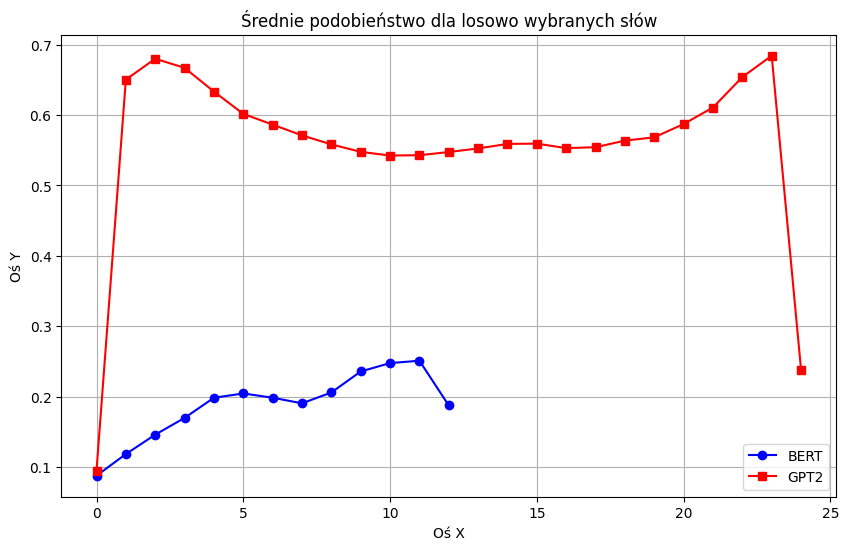

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(range(len(bert_layers_sim)), bert_layers_sim, label='BERT', color='blue', marker='o')
plt.plot(range(len(gpt2_layers_sim)), gpt2_layers_sim, label='GPT2', color='red', marker='s')

plt.title('Średnie podobieństwo dla losowo wybranych słów')
plt.xlabel('Oś X')
plt.ylabel('Oś Y')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
words_to_check = random.sample([value for value in words.values() if len(value) >= 5], 100)
words_to_check

[[(5803, 5), (7521, 12), (28528, 4), (34829, 24), (60168, 36)],
 [(15122, 2),
  (15123, 4),
  (15124, 3),
  (16300, 3),
  (16301, 6),
  (16302, 7),
  (16303, 4),
  (16304, 5),
  (16305, 8),
  (16306, 4),
  (16307, 3),
  (16365, 12)],
 [(5127, 2),
  (20591, 9),
  (20882, 12),
  (24270, 0),
  (24575, 1),
  (25644, 7),
  (28774, 33),
  (30087, 4),
  (30310, 11),
  (30506, 27),
  (31909, 5),
  (33224, 13),
  (34696, 20),
  (44008, 0),
  (51523, 24)],
 [(18006, 5),
  (23546, 7),
  (23547, 1),
  (23548, 2),
  (23550, 0),
  (23551, 6),
  (23552, 3)],
 [(6083, 6),
  (6970, 27),
  (10000, 1),
  (10467, 0),
  (20154, 11),
  (21123, 6),
  (22788, 14),
  (25149, 16),
  (28465, 9),
  (31252, 4),
  (31503, 11),
  (32642, 17),
  (34736, 20),
  (37735, 12),
  (37736, 19),
  (37744, 2),
  (40591, 2),
  (40970, 14),
  (40974, 6),
  (40974, 17),
  (42683, 8),
  (42683, 19),
  (42683, 34),
  (42684, 6),
  (46318, 8),
  (46318, 25),
  (46466, 17),
  (48537, 9),
  (56653, 8),
  (57133, 13),
  (61585, 17),
 

In [103]:
word_dict = {}
for word in words_to_check:
    for sentence, position in word:
        word = sentences[sentence]['lemma'][position]
        if word not in word_dict:
            word_dict[word] = []  # Initialize an empty list for the word
        word_dict[word].append((sentence, position))  # Append the tuple

In [104]:
word_dict

{'rehabilitacyjny': [(5803, 5),
  (7521, 12),
  (28528, 4),
  (34829, 24),
  (60168, 36)],
 'cieniuchny': [(15122, 2),
  (15123, 4),
  (15124, 3),
  (16300, 3),
  (16301, 6),
  (16302, 7),
  (16303, 4),
  (16304, 5),
  (16305, 8),
  (16306, 4),
  (16307, 3),
  (16365, 12)],
 'lada': [(5127, 2),
  (20591, 9),
  (20882, 12),
  (24270, 0),
  (24575, 1),
  (25644, 7),
  (28774, 33),
  (30087, 4),
  (30310, 11),
  (30506, 27),
  (31909, 5),
  (33224, 13),
  (34696, 20),
  (44008, 0),
  (51523, 24)],
 'fuszerka': [(18006, 5),
  (23546, 7),
  (23547, 1),
  (23548, 2),
  (23550, 0),
  (23551, 6),
  (23552, 3)],
 'samoobrona': [(6083, 6),
  (6970, 27),
  (10000, 1),
  (10467, 0),
  (20154, 11),
  (21123, 6),
  (22788, 14),
  (25149, 16),
  (28465, 9),
  (31252, 4),
  (31503, 11),
  (32642, 17),
  (34736, 20),
  (37735, 12),
  (37736, 19),
  (37744, 2),
  (40591, 2),
  (40970, 14),
  (40974, 6),
  (40974, 17),
  (42683, 8),
  (42683, 19),
  (42683, 34),
  (42684, 6),
  (46318, 8),
  (46318, 25),

In [256]:
def calculate_context_specificity(word_to_check, model):
    word_embeddings_for_each_sentence = [get_word_in_sentence_embeddings(sentence_i=sentence_id, word_i=word_position, model=model) for (sentence_id, word_position) in word_to_check]

    #list layerow, w kazdym layerze lista embedingow, kazdy element to embeding z danego zdania
    layers_embeddings = [[torch.Tensor(embeddings[i]).detach().numpy() for embeddings in word_embeddings_for_each_sentence if embeddings] for i in range(len(word_embeddings_for_each_sentence[0]))]
        
    avg_cos_sim = []

    for layer_embeddings in layers_embeddings:
        similarity_matrix = cosine_similarity(layer_embeddings)
        n = similarity_matrix.shape[0]
        mask = np.ones((n, n)) - np.eye(n)
        sim_no_diag = similarity_matrix * mask
        avg_cos_sim.append(1-np.mean(sim_no_diag))
        
    return avg_cos_sim


In [260]:
context_specifities_bert = []
for word_to_check in word_dict:
    context_specifities_bert.append(calculate_context_specificity(word_to_check=word_dict[word_to_check], model="bert"))

In [276]:
number_of_layers = len(context_specifities_bert[0])

In [277]:
mean_similarities_per_layer_bert = []

In [278]:
for i in range(number_of_layers):
    mean_sum = 0
    for context_bert in context_specifities_bert:
        if len(context_bert) == 0:
            continue
        mean_sum += context_bert[i]
    
    mean_sum = mean_sum / len(context_specifities_bert)
    mean_similarities_per_layer_bert.append(mean_sum)


In [271]:
context_specifities_gpt = []
for word_to_check in word_dict:
    context_specifities_gpt.append(calculate_context_specificity(word_to_check=word_dict[word_to_check], model="gpt2"))

In [279]:
number_of_layers = len(context_specifities_gpt[0])
mean_similarities_per_layer_gpt = []
for i in range(number_of_layers):
    mean_sum = 0
    for context_gpt in context_specifities_gpt:
        if len(context_gpt) == 0:
            continue
        mean_sum += context_gpt[i]
    
    mean_sum = mean_sum / len(context_specifities_gpt)
    mean_similarities_per_layer_gpt.append(mean_sum)

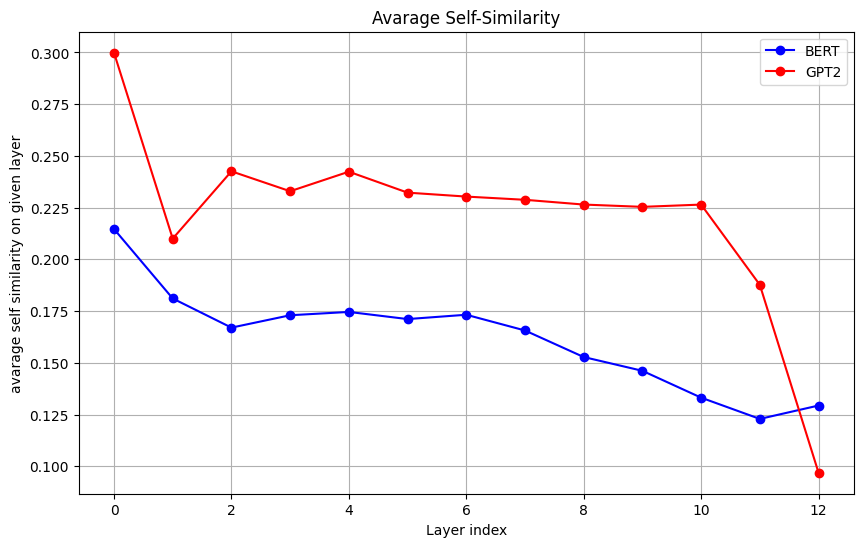

In [281]:
plt.figure(figsize=(10, 6))

plt.plot(range(len(mean_similarities_per_layer_bert)), mean_similarities_per_layer_bert, label='BERT', color='blue', marker='o')
plt.plot(range(len(mean_similarities_per_layer_gpt)), mean_similarities_per_layer_gpt, label='GPT2', color='red', marker='o')

plt.title('Avarage Self-Similarity')
plt.xlabel('Layer index')
plt.ylabel('avarage self similarity on given layer')

plt.legend()
plt.grid(True)
plt.show()